In [2]:
import sys

!'{sys.executable}' -m pip install --upgrade pip
!'{sys.executable}' -m pip install gurobipy
!'{sys.executable}' -m pip install cvxpy
!'{sys.executable}' -m pip install numpy
!'{sys.executable}' -m pip install jupyter-matlab-proxy
!'{sys.executable}' -m pip install matplotlib
!'{sys.executable}' -m pip install multiprocess
#!'{sys.executable}' -m pip install matlabengine

Generic probability distribution histogram code + some helper functions here

In [3]:
import math
import numpy as np
#import multiprocessing as mp
import multiprocess as mp
import itertools
from collections import defaultdict

def push_multinomial(n, k, occ=1):
    return math.lgamma(n + k * occ + 1) - math.lgamma(n + 1) - occ * math.lgamma(k + 1)

class DistHistogram:
    def __init__(self, hist = defaultdict(int)):
        self.hist = hist

    # If the histogram actually represents a prob distribution
    def check_integrity(self):
        if not math.isclose(1.0, sum(self.hist[p] * p for p in self.hist)):
            raise Exception("Bad histogram: {}".format(str(self.hist)))

    # Generate a fingerprint
    def generate_fingerprint(self, k):
        self.check_integrity()
        n = sum(self.hist[p] for p in self.hist)
        dist = np.concatenate([[p] * self.hist[p] for p in self.hist])
        hist = np.random.multinomial(k, dist, size=1)
        unique, counts = np.unique(hist, return_counts=True)
        fingerprint = dict(zip(unique, counts))
        if (zero := n - sum(fingerprint[f] for f in fingerprint)) != 0:
            fingerprint[0] = zero
        return fingerprint

    def __str__(self):
        return str([(p,self.hist[p]) for p in self.hist])
    
# Get true probability of obtaining a fingerprint 
# Speedup calculation with vectorization
def get_probabilities(dists, fingerprint):
    # Needs to have all distributions of the same ??-point structure
    pts = {len(dist.hist) for dist in dists}
    if len(pts) > 1:
        print("pts: ", pts)
        print("dists: ", [d.__str__() for d in dists])
        print("fingerprint: ", fingerprint)
        raise Exception("All distributions need to have the same ??-point structure")
    k, pts = sum(fingerprint[f] * f for f in fingerprint), pts.pop()
    log_zero_arr = lambda : np.full((1, m), -np.inf, dtype=float)

    m = len(dists)
    lps, ys = np.log(np.transpose([list(dist.hist.keys()) for dist in dists])), np.array([list(dist.hist.values()) for dist in dists])
    coefficients = np.full((1, m), math.lgamma(k + 1))
    for f in fingerprint:
        coefficients -= fingerprint[f] * math.lgamma(f + 1)
    for y in np.transpose(ys):
        coefficients += np.vectorize(math.lgamma)(y + 1)
    dp = defaultdict(log_zero_arr, {np.zeros(pts).tobytes(): coefficients})

    # Partition lazy generator
    def partition(size, array, value, occ):
        ind = array.size
        if ind == pts - 1:
            i = size
            new_value = value - math.lgamma(i + 1) + occ * i * lps[ind]
            new_array = np.concatenate([array, [i]])
            yield (new_array, new_value)
        else:
            for i in range(size + 1):
                new_value = value - math.lgamma(i + 1) + occ * i * lps[ind]
                new_array = np.concatenate([array, [i]])
                yield from partition(size - i, new_array, new_value, occ)

    for occ, frq in fingerprint.items():
        new_dp = defaultdict(log_zero_arr)
        for arr, val in partition(frq, np.array([]), np.full((1, m), 0.0, dtype=float), occ):
            for prev_arr_byte, prev_val in dp.items():
                prev_arr = np.frombuffer(prev_arr_byte)
                idx = (arr + prev_arr).tobytes()
                new_dp[idx] = np.logaddexp(new_dp[idx], val + prev_val)
        dp = new_dp
    ans = np.exp([dp[np.array(ys[i], dtype=float).tobytes()][0, i] for i in range(m)])
    return ans

def get_probabilities_no_multithread(dists, fingerprints):
    return np.transpose([get_probabilities(dists, f) for f in fingerprints])

def get_probabilities_multithread(dists, fingerprints):
    pool = mp.Pool(processes=16)
    return np.transpose(pool.starmap(get_probabilities, zip(itertools.repeat(dists), fingerprints)))

def get_probabilities_nonuniform(dists, fingerprints):
    #print("dists: ", [(a.hist, b.hist) for (a,b) in dists])
    #print("fingerprints: ", fingerprints)
    
    """
    d1s = [a for (a,_,_) in dists]
    d2s = [b for (_,b,_) in dists]
    ps = [p for (_,_,p) in dists]
    """

    d1s = []
    d2s = []
    ps = []

    for d in dists:
        (a,b,p) = d
        d1s.append(a)
        d2s.append(b)
        ps.append(p)
    
    p1s = np.transpose(get_probabilities_multithread(d1s, [f1 for (f1, _) in fingerprints]))
    p2s = np.transpose(get_probabilities_multithread(d2s, [f2 for (_, f2) in fingerprints]))

    """
    print("p1s: ", p1s)
    print("p2s: ", p2s)

    print("--------- Begin Test ----------")
    for (f1, f2) in fingerprints:
        print("Computing get_probabilities(" + str([d.hist for d in d2s]) + ", " + str(f2) + "):")
        print("    Result: " + str(get_probabilities(d2s, f2)))
    print("---------- End Test -----------")
    """

    def jprob(k,j,p):
        return np.exp(math.lgamma(k + 1) - math.lgamma(k - j + 1) - math.lgamma(j + 1) + j * math.log(p) + (k-j) * math.log(1-p))

    ans = []
    for i in range(len(fingerprints)):
        (f1, f2) = fingerprints[i]
        j=sum(f1[f] * f for f in f1)
        k=j + sum(f2[f] * f for f in f2)

        ans.append([jprob(k,j,p)*a*b for a,b,p in zip(p1s[i],p2s[i],ps)])
    return np.transpose(ans)

Generic tester + semilinear tester

In [4]:
class SemilinearTester: #this might not be entirely clean if the worst case distribution changes due to probabilism
    def __init__(self, c):
        self.c = c

    def get_coefficient(self, f):
        return sum([cnt * self.c[0][i] for i, cnt in f[0].items()])+sum([cnt * self.c[1][i] for i, cnt in f[1].items()])

    def optimize(self, lo, hi, fs, prob_hypo, prob_alts):
        def binary_search(lo, hi, pred, eps=1e-9):
            # assuming that pred(lo) is true and pred(hi) is false
            while lo + eps < hi:
                mi = (lo + hi) / 2
                if pred(mi):
                    lo = mi
                else:
                    hi = mi
            return lo, hi

        def predicate(t):
            verdict = np.array([self.get_coefficient(f) >= t for f in fs], dtype=float)
            t1 = (prob_hypo @ verdict)[0]
            t2 = np.max(prob_alts @ (1 - verdict))
            return t1 > t2
    
        self.lo, self.hi = binary_search(lo, hi, predicate)
        verdict_lo = np.array([self.get_coefficient(f) >= self.lo for f in fs], dtype=float)
        t1_lo = (prob_hypo @ verdict_lo)[0]
        t2_lo = np.max(prob_alts @ (1 - verdict_lo))
        verdict_hi = np.array([self.get_coefficient(f) >= self.hi for f in fs], dtype=float)
        t1_hi = (prob_hypo @ verdict_hi)[0]
        t2_hi = np.max(prob_alts @ (1 - verdict_hi))
        # solve t1_lo + (t1_hi - t1_lo) * self.tb = t2_lo + (t2_hi - t2_lo) * self.tb
        self.tb = (t1_lo - t2_lo) / ((t1_lo - t1_hi) - (t2_lo - t2_hi))
        return np.log(t1_lo + (t1_hi - t1_lo) * self.tb)

    def single_verdict(self, f):
        if (coef := self.get_coefficient(f)) < self.lo:
            return 0
        elif coef > self.hi:
            return 1
        else:
            return self.tb # this can be changed to a bernoulli sample with probability self.tb

    def multiple_verdicts(self, fs):
        return np.array([self.single_verdict(f) for f in fs], dtype=float)


Generating all alternative two-point distributions, sampling fingerprints, and generating probabilities

In [138]:
import copy

n, k = 30,30
eps = 0.9
fg_size = 20000
bias = 0.5

hypo = DistHistogram({1/n: n})
alts = []
for q in range(1, n):
    # x1 * q + x2 * (n - q) = 1
    # (1 / n - x1) * q + (x2 - 1 / n) * (n - q) = eps
    x1, x2 = (2 * q - n * eps) / (2 * n * q), (2 * n + n * eps - 2 * q) / (2 * n * (n - q))
    if 0 < x1 <= 1 and 0 < x2 <= 1:
        alts.append(DistHistogram({x1: q, x2: n - q}))

def generate_fingerprint(n, k, mi, dct):
    if n == 1:
        dct[k] += 1
        yield dict(dct)
    else:
        if n * (mi + 1) <= k:
            yield from generate_fingerprint(n, k, mi + 1, copy.deepcopy(dct))
        dct[mi] += 1
        yield from generate_fingerprint(n - 1, k - mi, mi, dct)

fingerprints = list(generate_fingerprint(n, k, 0, defaultdict(int)))

def generate_fingerprint_nonuniform(n,k):
    ans=[]
    for j in range(0,k+1):
        ans += [(f1,f2) for f1 in generate_fingerprint(2, j, 0, defaultdict(int)) for f2 in generate_fingerprint(n,k-j,0,defaultdict(int))]

    return ans

# Distribution with two heavy elements with total probability p, and n light elements with total probability 1-p.
def hypo_dist(p):
    return (DistHistogram({1/2: 2}), DistHistogram({1/n: n}), p)

# Slighly change the two heavy elements
def alt_dists(p, eps):
    assert (eps < p)
    return [(DistHistogram({1/2-eps/2/p: 1, 1/2+eps/2/p:1}), DistHistogram({1/n: n}), p)]

# Slighly change each of the light elements
def alt_dists2(p, eps):
    alts = []
    for q in range(1, n):
        x1, x2 = (2 * q - n * eps/(1-p)) / (2 * n * q), (2 * n + n * eps/(1-p) - 2 * q) / (2 * n * (n - q))
        if 0 < x1 <= 1 and 0 < x2 <= 1:
            alts.append((DistHistogram({1/2: 2}), DistHistogram({x1: q, x2: n - q}), p))
    
    return alts

# Change the weighting balance between the light and heavy elements
def alt_dists3(p, eps):
    assert (eps < min(p,1-p))

    return [(DistHistogram({1/2: 2}), DistHistogram({1/n: n}), p+eps), (DistHistogram({1/2: 2}), DistHistogram({1/n: n}), p-eps)]

# --- Begin oneheavy Experiment ---

def oneheavy_generate_fingerprint_nonuniform(n,k):
    ans=[]
    for j in range(0,k+1):
        ans += [(f1,f2) for f1 in generate_fingerprint(1, j, 0, defaultdict(int)) for f2 in generate_fingerprint(n,k-j,0,defaultdict(int))]
    return ans

# Distribution with one heavy element with probability p, and n light elements with total probability 1-p.
def oneheavy_hypo_dist(p):
    return (DistHistogram({1: 1}), DistHistogram({1/n: n}), p)

# Slighly change each of the light elements
def oneheavy_alt_dists2(p, eps):
    alts = []
    for q in range(1, n):
        x1, x2 = (2 * q - n * eps/(1-p)) / (2 * n * q), (2 * n + n * eps/(1-p) - 2 * q) / (2 * n * (n - q))
        if 0 < x1 <= 1 and 0 < x2 <= 1:
            alts.append((DistHistogram({1: 1}), DistHistogram({x1: q, x2: n - q}), p))
    
    return alts

# Change the weighting balance between the light and heavy element
def oneheavy_alt_dists3(p, eps):
    assert (eps < 2*min(p,1-p))

    return [(DistHistogram({1: 1}), DistHistogram({1/n: n}), p+eps/2), (DistHistogram({1: 1}), DistHistogram({1/n: n}), p-eps/2)]

# Mixture of type 2 and 3 alternatives, weighted by frac for part 3 and 1-frac for part 2
def oneheavy_alt_dists_hybrid1(p, eps, frac):
    eps1 = eps/2*frac
    eps2 = eps*(1-frac)/(1/2-eps1)
    
    assert (eps1 < min(p,1-p))

    """
    alts = []
    for q in range(1, n):
        # x1, x2 = (2 * q - n * eps2/(1-p-eps1)) / (2 * n * q), (2 * n + n * eps2/(1-p-eps1) - 2 * q) / (2 * n * (n - q))

        x1, x2 = (1-p)/n + (eps-2*eps1)/(2*q), (1-p)/n - eps/(2*(n-q))

        if 0 < x1 <= 1 and 0 < x2 <= 1:
            alts.append((DistHistogram({1: 1}), DistHistogram({x1: q, x2: n - q}), p+eps1))
    
    for q in range(1, n):
        # x1, x2 = (2 * q - n * eps2/(1-p+eps1)) / (2 * n * q), (2 * n + n * eps2/(1-p+eps1) - 2 * q) / (2 * n * (n - q))

        x1, x2 = (1-p)/n + eps/(2*q), (1-p)/n + (2*eps1-eps)/(2*(n-q))

        if 0 < x1 <= 1 and 0 < x2 <= 1:
            alts.append((DistHistogram({1: 1}), DistHistogram({x1: q, x2: n - q}), p-eps1))

    return alts
    """


    if(np.isclose(eps2, 0)):
        return [(DistHistogram({1: 1}), DistHistogram({1/n: n}), p+eps1), (DistHistogram({1: 1}), DistHistogram({1/n: n}), p-eps1)]

    alts = []
    for q in range(1, n):
        x1, x2 = (2 * q - n * eps2/(1-p)) / (2 * n * q), (2 * n + n * eps2/(1-p) - 2 * q) / (2 * n * (n - q))
        if 0 < x1 <= 1 and 0 < x2 <= 1:
            alts.append((DistHistogram({1: 1}), DistHistogram({x1: q, x2: n - q}), p+eps1))
    return alts

def oneheavy_alt_dists_hybrid2(p, eps, frac):
    eps1 = eps/2*frac
    eps2 = eps*(1-frac)/(1/2+eps1)
    
    assert (eps1 < min(p,1-p))

    """
    alts = []
    for q in range(1, n):
        # x1, x2 = (2 * q - n * eps2/(1-p-eps1)) / (2 * n * q), (2 * n + n * eps2/(1-p-eps1) - 2 * q) / (2 * n * (n - q))

        x1, x2 = (1-p)/n + (eps-2*eps1)/(2*q), (1-p)/n - eps/(2*(n-q))

        if 0 < x1 <= 1 and 0 < x2 <= 1:
            alts.append((DistHistogram({1: 1}), DistHistogram({x1: q, x2: n - q}), p+eps1))
    
    for q in range(1, n):
        # x1, x2 = (2 * q - n * eps2/(1-p+eps1)) / (2 * n * q), (2 * n + n * eps2/(1-p+eps1) - 2 * q) / (2 * n * (n - q))

        x1, x2 = (1-p)/n + eps/(2*q), (1-p)/n + (2*eps1-eps)/(2*(n-q))

        if 0 < x1 <= 1 and 0 < x2 <= 1:
            alts.append((DistHistogram({1: 1}), DistHistogram({x1: q, x2: n - q}), p-eps1))

    return alts
    """


    if(np.isclose(eps2, 0)):
        return [(DistHistogram({1: 1}), DistHistogram({1/n: n}), p+eps1), (DistHistogram({1: 1}), DistHistogram({1/n: n}), p-eps1)]

    alts = []
    for q in range(1, n):
        x1, x2 = (2 * q - n * eps2/(1-p)) / (2 * n * q), (2 * n + n * eps2/(1-p) - 2 * q) / (2 * n * (n - q))
        if 0 < x1 <= 1 and 0 < x2 <= 1:
            alts.append((DistHistogram({1: 1}), DistHistogram({x1: q, x2: n - q}), p-eps1))
    return alts

# --- End oneheavy Experiment ---

fingerprints_nonuniform = oneheavy_generate_fingerprint_nonuniform(n,k)

# seen = set()
# fingerprints = []
# while len(fingerprints) < fg_size:
#     f = hypo.generate_fingerprint(k)
#     t = tuple(f.items())
#     if t not in seen:
#         seen.add(t)
#         fingerprints.append(f)

# fingerprints = [hypo.generate_fingerprint(k) for _ in range(fg_size)]
#print(fingerprints_nonuniform)
prob_hypo = get_probabilities_nonuniform([oneheavy_hypo_dist(bias)], fingerprints_nonuniform)

print(prob_hypo)

prob_hypo = prob_hypo / prob_hypo.sum(axis=1)[:, np.newaxis] # normalization step
# prob_alts = np.array([[alt.get_probability(fingerprint) for fingerprint in fingerprints] for alt in alts])
prob_alts = np.vstack(( #get_probabilities_nonuniform(alt_dists(bias, eps), fingerprints_nonuniform), \
            get_probabilities_nonuniform(oneheavy_alt_dists2(bias, eps), fingerprints_nonuniform), \
            get_probabilities_nonuniform(oneheavy_alt_dists_hybrid1(bias, eps, 0.3333), fingerprints_nonuniform), \
            get_probabilities_nonuniform(oneheavy_alt_dists_hybrid2(bias, eps, 0.3333), fingerprints_nonuniform), \
            get_probabilities_nonuniform(oneheavy_alt_dists_hybrid1(bias, eps, 0.6667), fingerprints_nonuniform), \
            get_probabilities_nonuniform(oneheavy_alt_dists_hybrid2(bias, eps, 0.6667), fingerprints_nonuniform), \
            get_probabilities_nonuniform(oneheavy_alt_dists3(bias, eps), fingerprints_nonuniform)
))

print(prob_alts)

prob_alts = prob_alts / prob_alts.sum(axis=1)[:, np.newaxis] # normalization step

[[1.19983786e-21 5.21929471e-19 4.93223350e-17 ... 1.35041773e-08
  2.79396772e-08 9.31322575e-10]]


KeyError: 'pop from an empty set'

Solving linear program

In [133]:
#import matlab.engine
import io

# --2.783246248005155
# -2.5430245416741255 deterministic tester

lo, hi = -1e6, 1e6
p = 1/(n+1)
q = 0.5

"""
eng = matlab.engine.start_matlab()
domain_fractions = matlab.double([p,1-p])
probability_fractions = matlab.double([q,1-q])
c_matlab = np.transpose(eng.get_coefs2(n * 1.0, k * 1.0, eps * 1.0,domain_fractions,probability_fractions, stdout=io.StringIO()))
#if len(c_matlab) < k + 1:
#    c_matlab = np.pad(c_matlab, (0, k + 1 - len(c_matlab)), 'constant')
#print(c_matlab)

matlab_tester = SemilinearTester(c_matlab)
print("Our tester:\n")
print(matlab_tester.optimize(lo, hi, fingerprints_nonuniform, prob_hypo, prob_alts))
print(matlab_tester.lo, matlab_tester.hi, matlab_tester.tb)
"""

matlab_tester = SemilinearTester(np.transpose(np.loadtxt("cis.txt", delimiter=',')))
print("Our tester:\n")

our_delta = matlab_tester.optimize(lo, hi, fingerprints_nonuniform, prob_hypo, prob_alts)

print(our_delta)
print(matlab_tester.lo, matlab_tester.hi, matlab_tester.tb)

c_chi = np.array([[((i - (k*q) / (n*p)) ** 2 / ((k*q) / (n*p))) for i in range(k + 1)],[((i - (k*(1-q)) / (n*(1-p))) ** 2 / ((k*(1-q)) / (n*(1-p)))) for i in range(k + 1)]])

chi_squared_tester = SemilinearTester(c_chi)
print("chi_square:\n")

chi2_delta = chi_squared_tester.optimize(lo, hi, fingerprints_nonuniform, prob_hypo, prob_alts)

print(chi2_delta)
print(chi_squared_tester.lo, chi_squared_tester.hi, chi_squared_tester.tb)

with open("data40.txt", "a") as myfile:
    myfile.write(str(our_delta) + "," + str(chi2_delta) + "\n")

#c_tv = np.array([abs(i - k / n) for i in range(k + 1)])
#tv_tester = SemilinearTester(c_tv)
#print(tv_tester.optimize(lo, hi, fingerprints, prob_hypo, prob_alts))
#print(tv_tester.lo, tv_tester.hi, tv_tester.tb)

#c_singleton = -np.array([i == 1 for i in range(k + 1)], dtype=float)
#singleton_tester = SemilinearTester(c_singleton)
#print(singleton_tester.optimize(lo, hi, fingerprints, prob_hypo, prob_alts))
#print(singleton_tester.lo, singleton_tester.hi, singleton_tester.tb)

Our tester:

-2.003423205993872
-2.071544469295361 -2.0715444684071826 0.3825074582411112
chi_square:

-0.16986083617688177
38.05490196029382 38.054901961182 0.7723831072962785


[[-1.46320964 -1.35401368 -1.20178522 -1.2542183  -1.26242233 -1.27054874
  -1.2414332  -1.22366159 -1.22430703]
 [-0.03945179 -0.03945179 -0.03945179 -0.03945179 -0.03945179 -0.03945179
  -0.03945179 -0.03945179 -0.03945179]]
[[-2.26352252 -2.1163019  -1.92622748 -1.87104601 -1.66229819 -1.75430468
  -1.71017758 -1.69911826 -1.65620605]
 [-0.67917131 -0.19260183 -0.0125611  -0.01066751 -0.00940094 -0.00849421
  -0.00781304 -0.00728258 -0.0056197 ]]


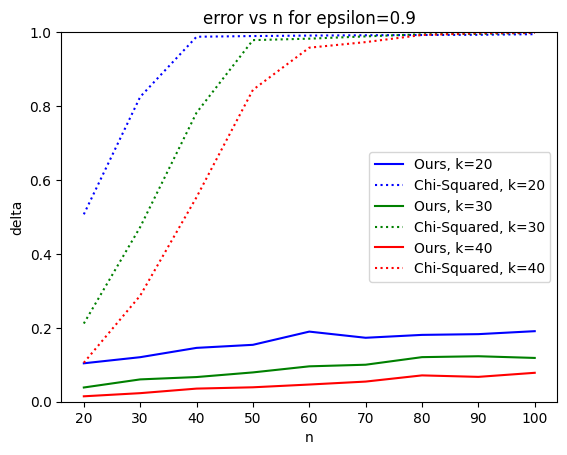

In [152]:
# print(*list(zip(x.value, fingerprints)), sep='\n')

import matplotlib.pyplot as plt

data10 = np.loadtxt("nonuniform_raw_datas10.csv", delimiter=',', skiprows=2, max_rows=2,usecols=(1,2,3,4,5,6,7,8,9))
data20 = np.loadtxt("nonuniform_raw_datas20.csv", delimiter=',', skiprows=2, max_rows=2,usecols=(1,2,3,4,5,6,7,8,9))
data30 = np.loadtxt("nonuniform_raw_datas30.csv", delimiter=',', skiprows=2, max_rows=2,usecols=(1,2,3,4,5,6,7,8,9))
data40 = np.loadtxt("nonuniform_raw_datas40.csv", delimiter=',', skiprows=2, max_rows=2,usecols=(1,2,3,4,5,6,7,8,9))

print(data10)
print(data20)

x=[i for i in range(20,110,10)]

#plt.plot(x, np.exp(data10[0,:]), 'r-', label ='Ours, k=10')
#plt.plot(x, np.exp(data10[1,:]), 'r:', label ='Chi-Squared, k=10')

plt.plot(x, np.exp(data20[0,:]), 'b-', label ='Ours, k=20')
plt.plot(x, np.exp(data20[1,:]), 'b:', label ='Chi-Squared, k=20')

plt.plot(x, np.exp(data30[0,:]), 'g-', label ='Ours, k=30')
plt.plot(x, np.exp(data30[1,:]), 'g:', label ='Chi-Squared, k=30')

plt.plot(x, np.exp(data40[0,:]), 'r-', label ='Ours, k=40')
plt.plot(x, np.exp(data40[1,:]), 'r:', label ='Chi-Squared, k=40')

plt.xlabel("n")
plt.ylabel("delta")
plt.ylim(0,1)
plt.legend()
plt.title('error vs n for epsilon=0.9')
plt.show()

(4, 50)


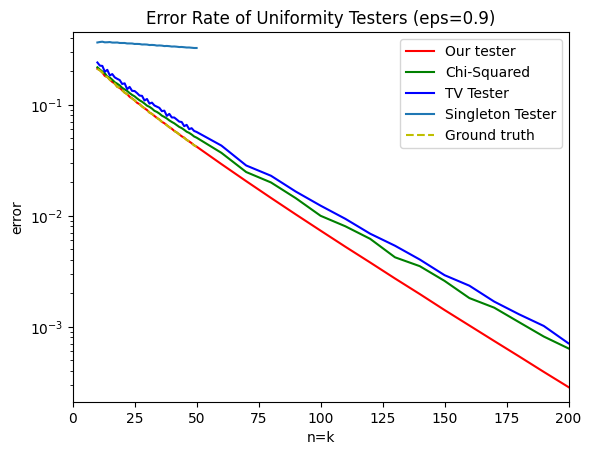

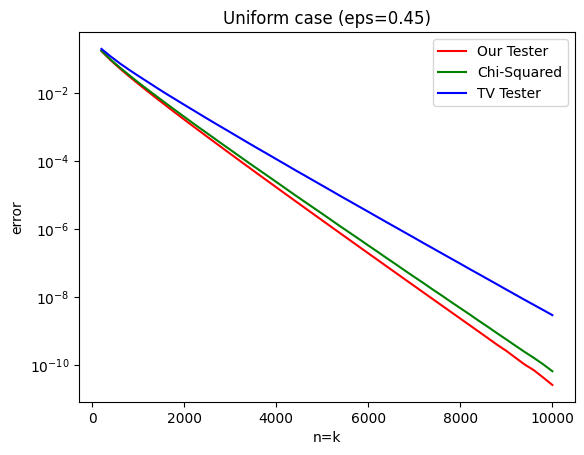

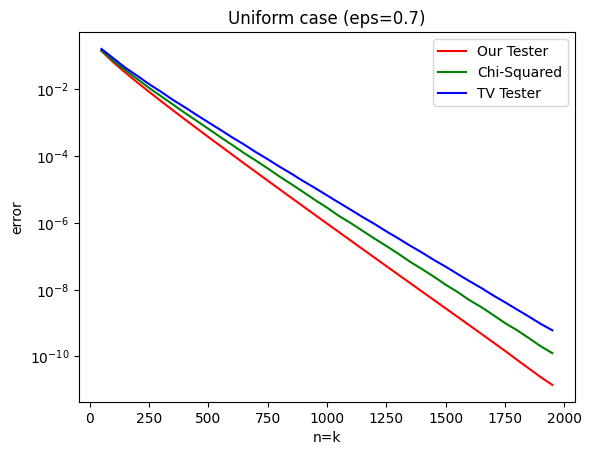

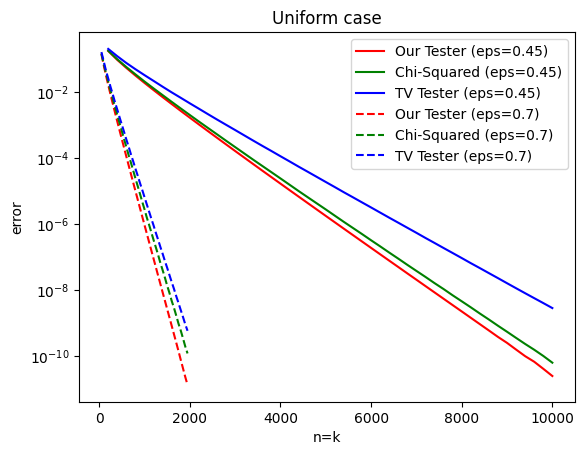

In [234]:
data1 = np.loadtxt("uniform_raw_datas.csv", delimiter=',', skiprows=1, max_rows=6,usecols=range(1,42))
data2 = np.loadtxt("uniform-new.csv", delimiter=',', skiprows=0, max_rows=6,usecols=range(1,42))

data3 = np.loadtxt("uniform-p45.csv", delimiter=',', skiprows=1, max_rows=4,usecols=range(1,51))
data4 = np.loadtxt("uniform-p7.csv", delimiter=',', skiprows=1, max_rows=4,usecols=range(1,40))

print(data3.shape)

x=[i for i in range(10,51)]


#plt.plot(x, np.exp(data10[0,:]), 'r-', label ='Ours, k=10')
#plt.plot(x, np.exp(data10[1,:]), 'r:', label ='Chi-Squared, k=10')

plt.plot(np.hstack((data1[0,:],data2[0,:])), np.exp(np.hstack((data1[2,:],data2[1,:]))), 'r-', label ='Our tester')
plt.plot(np.hstack((data1[0,:],data2[0,:])), np.exp(np.hstack((data1[3,:],data2[2,:]))), 'g-', label ='Chi-Squared')
plt.plot(np.hstack((data1[0,:],data2[0,:])), np.exp(np.hstack((data1[4,:],data2[3,:]))), 'b-', label ='TV Tester')
plt.plot(data1[0,:], np.exp(data1[5,:]), '-', label ='Singleton Tester')
plt.plot(data1[0,:], np.exp(data1[1,:]), 'y--', label ='Ground truth')

plt.semilogy()
plt.xlim(0,200)
plt.ylim(0.00021,0.45)
plt.xlabel("n=k")
plt.ylabel("error")
plt.legend()
plt.title('Error Rate of Uniformity Testers (eps=0.9)')
plt.show()


plt.plot(data3[0,:], np.exp(data3[1,:]), 'r-', label ='Our Tester')
plt.plot(data3[0,:], np.exp(data3[2,:]), 'g-', label ='Chi-Squared')
plt.plot(data3[0,:], np.exp(data3[3,:]), 'b-', label ='TV Tester')
plt.semilogy()
plt.xlabel("n=k")
plt.ylabel("error")
plt.legend()
plt.title('Error Rate of Uniformity Testers (eps=0.45)')
plt.show()

plt.plot(data4[0,:], np.exp(data4[1,:]), 'r-', label ='Our Tester')
plt.plot(data4[0,:], np.exp(data4[2,:]), 'g-', label ='Chi-Squared')
plt.plot(data4[0,:], np.exp(data4[3,:]), 'b-', label ='TV Tester')
plt.semilogy()
plt.xlabel("n=k")
plt.ylabel("error")
plt.legend()
plt.title('Error Rate of Uniformity Testers (eps=0.7)')
plt.show()


plt.plot(data3[0,:], np.exp(data3[1,:]), 'r-', label ='Our Tester (eps=0.45)')
plt.plot(data3[0,:], np.exp(data3[2,:]), 'g-', label ='Chi-Squared (eps=0.45)')
plt.plot(data3[0,:], np.exp(data3[3,:]), 'b-', label ='TV Tester (eps=0.45)')

plt.plot(data4[0,:], np.exp(data4[1,:]), 'r--', label ='Our Tester (eps=0.7)')
plt.plot(data4[0,:], np.exp(data4[2,:]), 'g--', label ='Chi-Squared (eps=0.7)')
plt.plot(data4[0,:], np.exp(data4[3,:]), 'b--', label ='TV Tester (eps=0.7)')
plt.semilogy()
plt.xlabel("n=k")
plt.ylabel("error")
plt.legend()
plt.title('Error Rate of Uniformity Testers (eps=0.45,0.7)')
plt.show()